In [134]:
import numpy as np
import math
import helicopter
import tqdm
import random
import matplotlib.pyplot as plt
import statistics as st
import time
import copy 

In [135]:
class ITERABLE_STEPS():
    def __init__(self, H, actions):        
        self.H_ref = H      
        self.actions = actions
        self.index = 0
        self.TOP = len(actions)
        return None

    def __iter__(self):
        return self

    def __next__(self):
        if self.index == self.TOP:
            raise StopIteration
        else:
            i = self.index
            self.index += 1
            return (self.actions[i], # Different actions
                    self.H_ref)      #Used heuristic

    def __del__(self):
        return None

In [136]:
def Heuristic(observation,vision):
    grid, pos, remain_steps= observation
    
    #Add borders in Grid perimeter according to vision range of helicopter, in order
    #to explore without boundary limits (Example: 2 vision add 2 cells at each side of Grid)
    Pad_grid=ExpandGrid(grid,vision)    
    
    #Get neighborhood in agent current position and vision range
    neighborhood= get_neighborhood(Pad_grid,pos,vision) 
    
    #Count fire cells by zone(8 zones)    
    burned_densities={}
    
    #Up Zone
    up_zone=neighborhood[ 0:neighborhood.shape[0]-(vision+1),0:neighborhood.shape[1]] #Get Up Zone
    up_burned=Count_Burned_Trees(env,up_zone) #Get fire cells in up zone    
    burned_densities["up"]=up_burned #Add zone and fire density to dictionary
    
    #Up Left Zone
    up_left_zone=neighborhood[ 0:neighborhood.shape[0]-(vision+1),0:neighborhood.shape[0]-(vision+1) ]
    up_left_burned=Count_Burned_Trees(env,up_zone)   
    burned_densities["up_left"]=up_left_burned    
    
    #Up Right Zone
    up_right_zone=neighborhood[ 0:neighborhood.shape[0]-(vision+1),neighborhood.shape[0]-vision:neighborhood.shape[0] ]
    up_right_burned=Count_Burned_Trees(env,up_right_zone)   
    burned_densities["up_right"]=up_right_burned    
    
    #Down Zone
    down_zone=neighborhood[ neighborhood.shape[0]-vision:neighborhood.shape[0],0:neighborhood.shape[1]]
    down_burned=Count_Burned_Trees(env,down_zone)    
    burned_densities["down"]=down_burned
    
    #Down Left
    down_left_zone=neighborhood[ neighborhood.shape[0]-vision:neighborhood.shape[0], 0:neighborhood.shape[0]-(vision+1) ]
    down_left_burned=Count_Burned_Trees(env,down_left_zone)    
    burned_densities["down_left"]=down_left_burned    
    
    #Down Right
    down_right_zone=neighborhood[ neighborhood.shape[0]-vision:neighborhood.shape[0], neighborhood.shape[0]-vision:neighborhood.shape[0] ]
    down_right_burned=Count_Burned_Trees(env,down_right_zone)   
    burned_densities["down_right"]=down_right_burned   
    
    #Left Zone
    left_zone=neighborhood[ 0:neighborhood.shape[0],0:neighborhood.shape[0]-(vision+1)]
    left_burned=Count_Burned_Trees(env,left_zone)    
    burned_densities["left"]=left_burned
    
    #Right Zone
    right_zone=neighborhood[ 0:neighborhood.shape[1],neighborhood.shape[0]-vision:neighborhood.shape[0]]
    right_burned=Count_Burned_Trees(env,right_zone)   
    burned_densities["right"]=right_burned
    
    #Action based on burned trees/zone
    actions= ((1,2,3),
              (4,5,6),
              (7,8,9))
    
    #Max function will return a (key,value) tuple of the maximum value from the dictionary
    mx_tuple = max(burned_densities.items(),key = lambda x:x[1]) 
    #Mx_tuple[1] indicates maximum dictionary items value
    max_list =[i[0] for i in burned_densities.items() if i[1]==mx_tuple[1]] 
    
    #Apply Heuristic Rules according to fire cells in each zone
    #If there are more than 1 max burn zone, choose randomly
    if len(max_list) > 1: 
        a=random.choice(max_list)
        if a=="up":
            action=actions[0][1]
        elif a=="down":
            action=actions[2][1]
        elif a=="left":
            action=actions[1][0]
        elif a=="right":
            action=actions[1][2]
        elif a=="up_left":
            action=actions[0][0]
        elif a=="up_right":
            action=actions[0][2]
        elif a=="down_left":
            action=actions[2][0]
        elif a=="down_right":
            action=actions[2][2]
    #If there is only one zone with max fire density (move in up,down,right,left or corners only)
    elif len(max_list)==1:
        if max_list[0]=="up":
            action=actions[0][1]
        elif max_list[0]=="down":
            action=actions[2][1]
        elif max_list[0]=="left":
            action=actions[1][0]
        elif max_list[0]=="right":
            action=actions[1][2]
        elif max_list[0]=="up_left":
            action=actions[0][0]
        elif max_list[0]=="up_right":
            action=actions[0][2]
        elif max_list[0]=="down_left":
            action=actions[2][0]
        elif max_list[0]=="down_right":
            action=actions[2][2]
        else:
            action=random.randint(1, 9)
    act=action        
    return act

In [137]:
#Receives a grid zone and count fire cells
def Count_Burned_Trees(env,zone):
    counter=0
    for row in range(zone.shape[0]):
        for col in range(zone.shape[1]):
            if zone[row][col]==env.fire:
                counter+=1
    return counter

In [138]:
#Get neighborhood of agent according to vision range
def get_neighborhood(grid,pos,vision):
    pos_row=pos[0]
    pos_col=pos[1]    
    neighborhood=grid[pos_row:pos_row+1+vision*2,pos_col:pos_col+1+vision*2]
    return neighborhood

In [139]:
def ExpandGrid(grid,vision):        
        size = grid.shape        
        PadGrid = np.zeros((size[0],size[1]), dtype=np.int16)        
        for i in range(size[0]):
            for j in range(size[1]):
                if(grid[i][j][0]==1):
                    PadGrid[i][j]=0
                elif(grid[i][j][1]==1):
                    PadGrid[i][j]=1
                else:
                    PadGrid[i][j]=2
        size=PadGrid.shape
        PadGrid2 = np.zeros((size[0]+2*vision,size[1]+2*vision), dtype=np.int16)
        PadGrid2[vision:-vision,vision:-vision] = PadGrid
        return PadGrid2

In [140]:
def Copy(env):
    n_env = helicopter.EnvMakerForestFire(init_pos_row=env.pos_row,init_pos_col=env.pos_col,n_row = env.n_row, n_col = env.n_col,
                                          p_tree = env.p_tree, p_fire =env.p_fire, moves_before_updating = env.moves_before_updating,
                                          reward_type = env.reward_type, reward_tree = env.reward_tree,reward_fire = env.reward_fire,
                                          reward_empty =env.reward_empty, reward_hit = env.reward_hit,sub_tree = env.sub_tree,
                                          sub_empty = env.sub_empty, sub_fire = env.sub_fire, sub_rock = env.sub_rock,sub_lake = env.sub_lake,
                                          ip_tree = env.ip_tree, ip_empty =env.ip_empty, ip_fire =env.ip_fire, ip_rock = env.ip_rock,
                                          ip_lake = env.ip_lake)
    n_env.grid = copy.deepcopy(env.grid)      
    n_env.total_reward = copy.deepcopy(env.total_reward)   
    n_env.total_hits=copy.deepcopy(env.total_hits)
    n_env.remaining_moves=copy.deepcopy(env.remaining_moves)
    
    return n_env

In [141]:
# Environment parameters
N_ROW = 16
N_COL = 16
Init_Row=7
Init_Col=7
P_FIRE = 0.03
P_TREE = 0.1
# Symbols for cells
TREE = 0
FIRE = 2
EMPTY = 1
FREEZE = 8 #Movements of Helicopter after update Automata

In [142]:
if __name__ == '__main__':
    #Create a new enviroment with initial parameters
    env = helicopter.EnvMakerForestFire(n_row = N_ROW, n_col = N_COL, p_tree = P_TREE, p_fire = P_FIRE,
                 init_pos_row = Init_Row, init_pos_col = Init_Col, moves_before_updating = FREEZE,  
                 tree = TREE, empty = EMPTY, fire = FIRE)
    observation = env.reset()
    #Rollout Variables
    N_TEST= 20       #Number of Training total simulations of Rollout
    N_STEPS=5      #Number of steps in rollout(50 updates of enviroment and 20*8 movements of agent)
    A=0.9           #Discount factor for future rewards
    K=8             #Rollout Steps on horizon for the heuristic 
    N_SAMPLES=3    #Number of samples trajectories in rollout to calculate expected value
    vision= 2       #Range to lookup in cells in helicpter heuristic  
    epsilon=0.99    #Epsilon for exploration in state space 

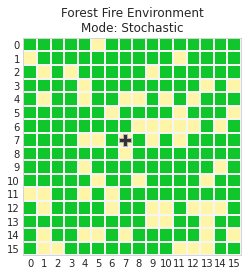

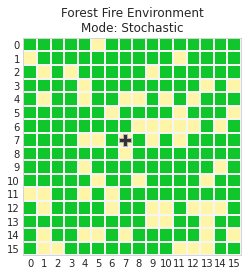

Copia


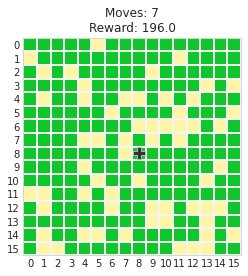

Original


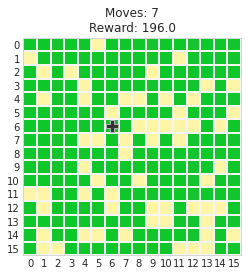

Copia


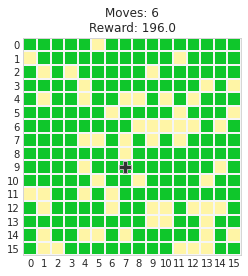

Original


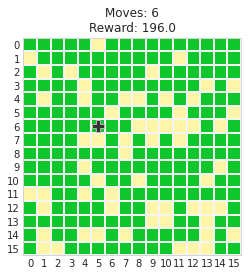

Copia


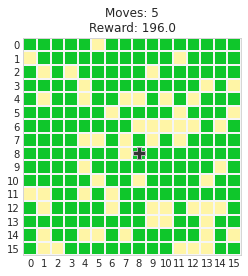

Original


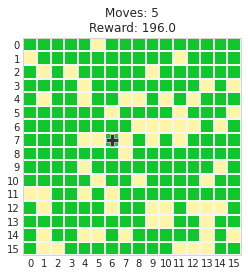

Copia


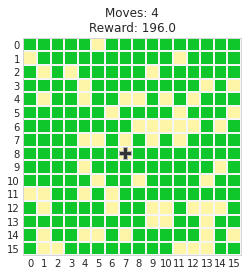

Original


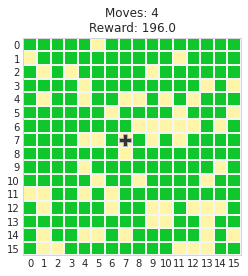

Copia


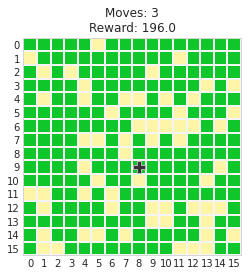

Original


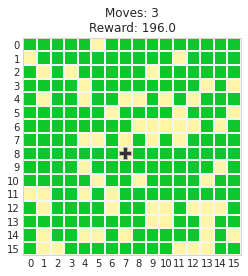

Copia


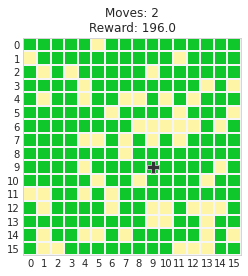

Original


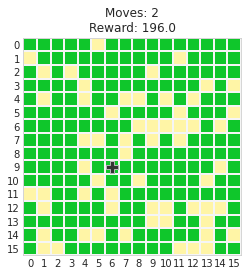

Copia


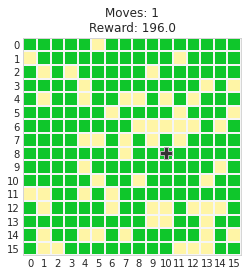

Original


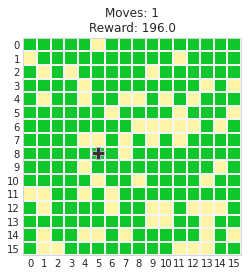

Copia


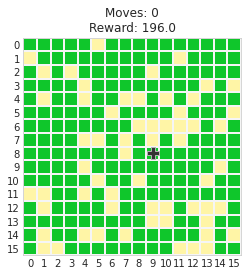

Original


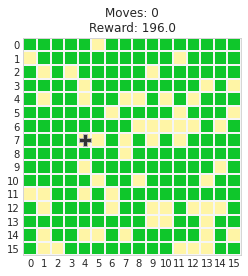

Copia


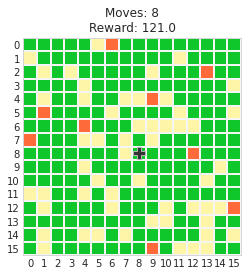

Original


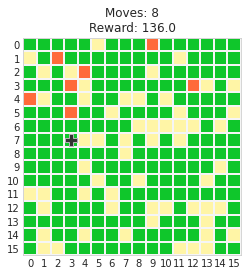

Copia


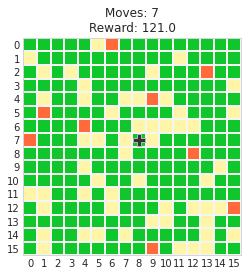

Original


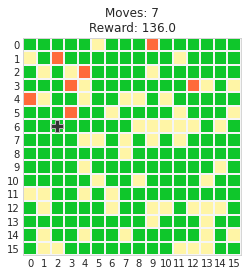

Copia


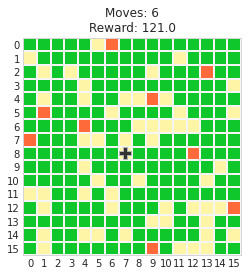

Original


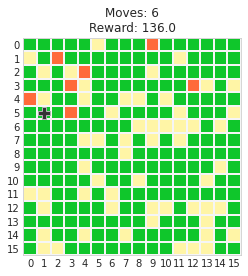

Copia


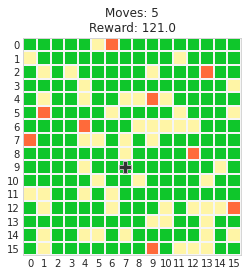

Original


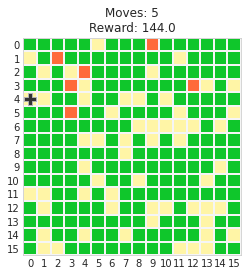

Copia


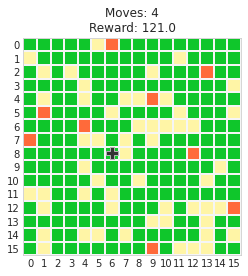

Original


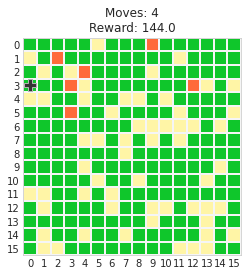

Copia


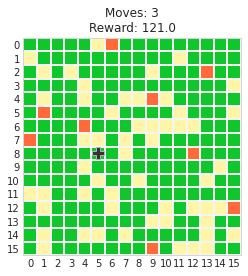

Original


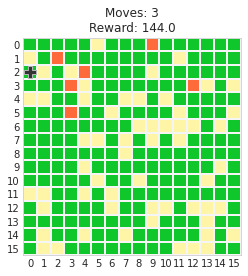

Copia


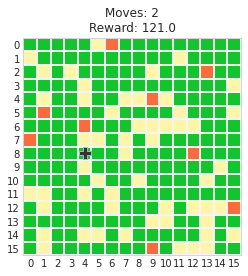

Original


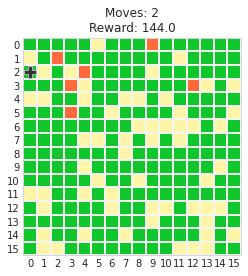

Copia


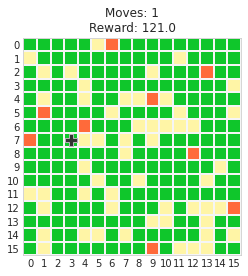

Original


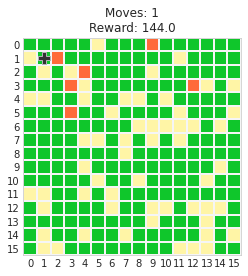

Copia


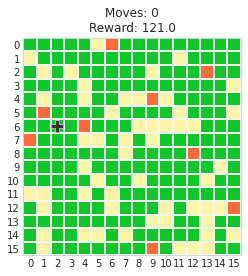

Original


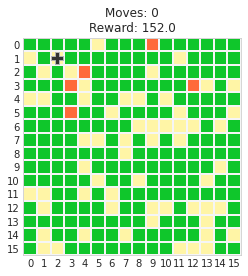

Copia


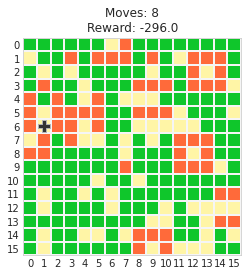

Original


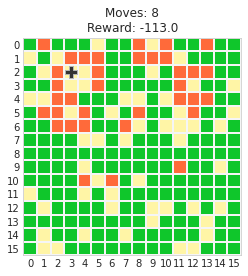

Copia


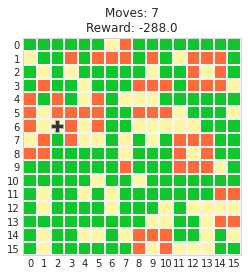

Original


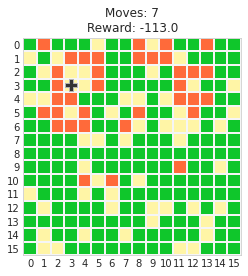

Copia


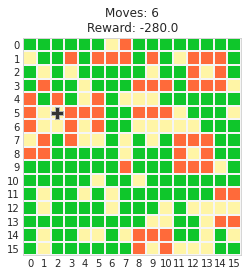

Original


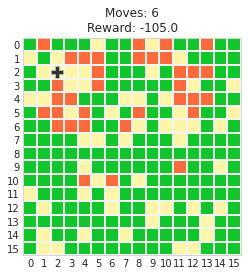

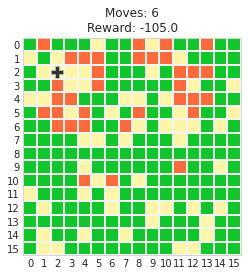

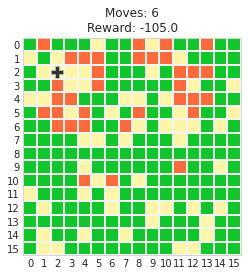

In [143]:
    env_1 = env.Copia()
    observation_1 = observation
    env.render()
    env_1.render()
    
    for n_test in range(N_TEST):
        h_action=Heuristic(observation_1,vision)
        observation_1, ro_cost, _, _ = env_1.step(h_action)
        h_action=Heuristic(observation,vision)
        observation, ro_cost, _, _ = env.step(h_action)
        print("Copia")
        env_1.render()
        print("Original")
        env.render()
    env.render()

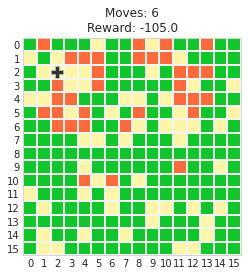

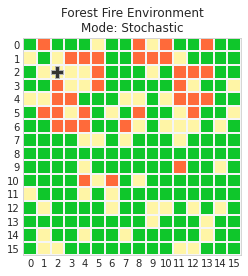

2517.0
2517.0
Direct Memories
140406273676112
140406287486608
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
Action 1
Acto: 1
Copia


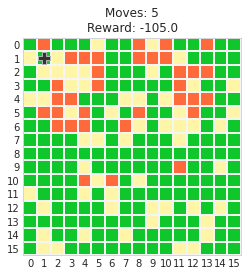

2412.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


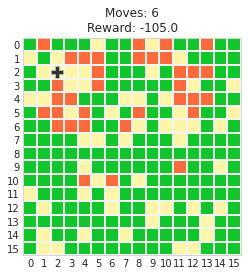

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 2
Acto: 6
Copia


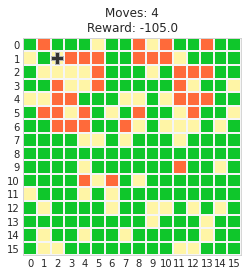

2307.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


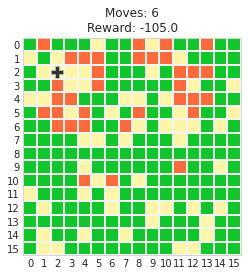

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 3
Acto: 6
Copia


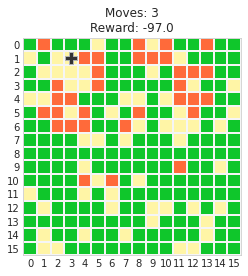

2210.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


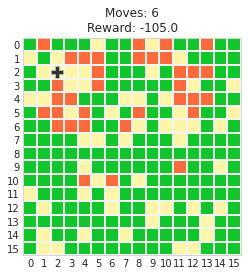

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 4
Acto: 6
Copia


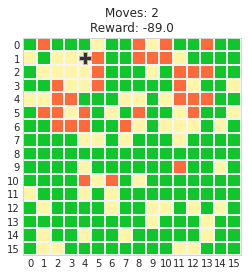

2121.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


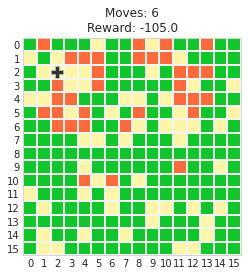

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 5
Acto: 8
Copia


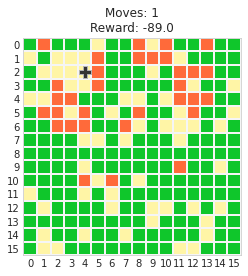

2032.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


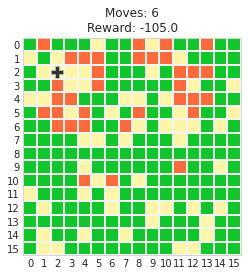

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 6
Acto: 8
Copia


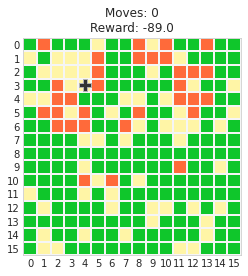

1943.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


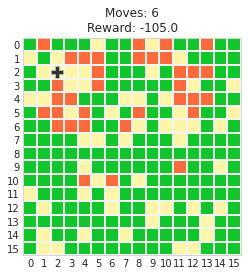

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 7
Acto: 4
Copia


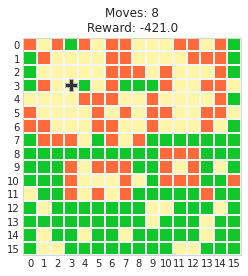

1522.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


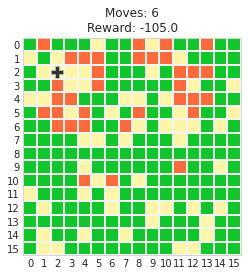

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 8
Acto: 9
Copia


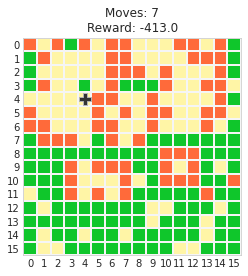

1109.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


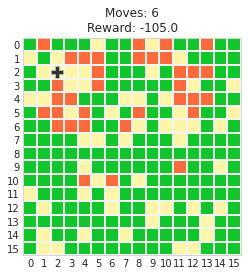

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0
Action 9
Acto: 6
Copia


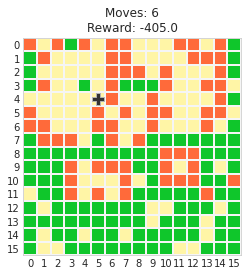

704.0
Original
[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]


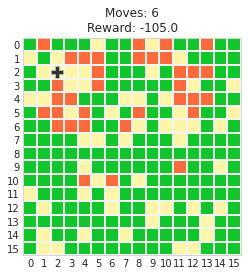

[[0 2 0 0 0 1 0 0 2 1 2 0 0 2 0 0]
 [1 0 1 2 2 2 0 0 2 2 2 1 0 0 0 0]
 [0 1 1 1 1 2 0 0 0 1 0 2 2 2 0 0]
 [0 0 2 1 1 2 0 0 0 0 0 2 1 0 0 1]
 [1 1 2 2 0 0 0 1 1 0 1 2 2 2 0 0]
 [0 2 2 1 2 0 1 0 2 0 0 1 2 0 0 1]
 [0 0 2 2 2 0 0 2 1 0 1 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0]
 [0 0 0 0 2 1 2 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0]]
2517.0


In [144]:
    env.render()    
    env_3=Copy(env)
    env_3.render()
    print(env.total_reward)
    print(env_3.total_reward)
    
    grid, pos, remain_steps= observation
    observation_3=observation
    
    actions= env.available_actions(pos)
    
    print("Direct Memories")
    z=id(env.grid)
    x=id(env_3.grid)
    print(z)
    print(x)
    NEXT_STEPS=ITERABLE_STEPS(Heuristic,actions)
    g=env.grid
    print(g)
    for action_step in NEXT_STEPS:
        print("Action",action_step[0])
        h_action=Heuristic(observation_3,vision)
        print("Acto:",h_action)
        observation_3, ro_cost, _, _ = env_3.step(h_action)
        print("Copia")
        env_3.render()
        print(env_3.total_reward)
        print("Original")
        env.grid=g
        print(g)
        env.render()
        print(env.grid)
        print(env.total_reward)